# 01: Data Simulation and Caching Workflow

This notebook demonstrates a robust workflow for generating simulated genetic and phenotype data for downstream analysis. 


**Workflow:**

1.  **Check for Cache:** The notebook first checks if a local copy of the required variant data exists.
2.  **Fetch or Load:** 
    *   If the local cache is found, the data is loaded instantly.
    *   If not, it performs a **one-time** from the `malariagen_data` cloud resource and saves the result to the local cache for all future runs.
3.  **Simulate & Assemble:** Using the now-available variant data, it simulates realistic phenotypes and assembles a final, analysis-ready `xarray.Dataset`

### 1. Setup & Imports

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../src"))
import pandas as pd
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from data.simulation import ResistanceSimulator
from utils.phenotype_utils import PhenotypeHelper

warnings.filterwarnings('ignore', category=UserWarning)

### 2. Fetch or Load Variant Data (with Caching)

In [2]:
# ### 2. Fetch or Load Variant Data (with Caching) ###

import os

# --- Configuration ---
# Define the variants we wants to study for this session.
VARIANTS_TO_FETCH = {
    "Vgsc_L995F_proxy": ("2L:2438000-2439000", 2438000),
    "Ace1_RDL_proxy": ("2R:3484107-3495790", 3484107),
}
# Define the path for the local data cache.
CACHE_PATH = '../data/gwas_preprocessed_variants.nc'


# --- Main Logic: Check for cache, otherwise fetch and create it. ---
if os.path.exists(CACHE_PATH):
    print(f"Loading pre-computed variant data from local cache: {CACHE_PATH}")
    variant_ds = xr.open_dataset(CACHE_PATH)
    sim = ResistanceSimulator()
    
else:
    print(f"Cache not found at '{CACHE_PATH}'. Fetching variants from the cloud...")
    sim = ResistanceSimulator()
    fetched_variants = {}
    for name, (region, pos) in VARIANTS_TO_FETCH.items():
        geno_array, _ = sim.fetch_variant_data(region, pos)
        fetched_variants[name] = geno_array
    
    # Combine the fetched data into a single dataset.
    variant_ds = sim.combine_snp_data(fetched_variants)
    
    # Save the newly fetched data to the cache for next time.
    print(f"\nSaving fetched data to cache: {CACHE_PATH}")
    os.makedirs(os.path.dirname(CACHE_PATH), exist_ok=True)
    variant_ds.to_netcdf(CACHE_PATH)

print("\n--- Variant Dataset Loaded ---")
display(variant_ds)

Cache not found at '../data/gwas_preprocessed_variants.nc'. Fetching variants from the cloud...


Fetching 2L:2438000-2439000 for 22605 samples from the cloud...
Fetching 2R:3484107-3495790 for 22605 samples from the cloud...

Saving fetched data to cache: ../data/gwas_preprocessed_variants.nc

--- Variant Dataset Loaded ---


<xarray.Dataset> Size: 3MB
Dimensions:        (samples: 22605, variants: 2, ploidy: 2)
Coordinates:
  * samples        (samples) <U29 3MB 'VBS00256-4651STDY7017184' ... 'SAMN152...
  * variants       (variants) <U16 128B 'Vgsc_L995F_proxy' 'Ace1_RDL_proxy'
Dimensions without coordinates: ploidy
Data variables:
    call_genotype  (samples, variants, ploidy) int32 362kB 2 1 2 0 0 ... 0 2 0 2

### 3. Simulate Phenotypes

In [3]:
# Extract the genotype arrays from the dataset for the simulation
g1 = variant_ds['call_genotype'].isel(variants=0).values
g2 = variant_ds['call_genotype'].isel(variants=1).values

# Simulate phenotypes using these genotypes
pheno_series = sim.simulate_phenotypes(g1, g2)

print("Simulated Phenotype Counts:")
print(pheno_series.value_counts())

Simulated Phenotype Counts:
1    19412
0     3193
Name: count, dtype: int64


### 4. Build Final Analysis-Ready Dataset

In [4]:
# Create the phenotype DataFrame
df_pheno = sim.create_phenotype_df(pheno_series)

# Merge phenotype and genotype data into the final analysis dataset
final_ds = PhenotypeHelper.create_dataset(df_pheno, variant_data=variant_ds)

print("--- Final Analysis-Ready Dataset ---")
display(final_ds)

--- Final Analysis-Ready Dataset ---


<xarray.Dataset> Size: 2MB
Dimensions:           (samples: 22605, variants: 2, ploidy: 2)
Coordinates:
  * samples           (samples) object 181kB 'VBS20179-5568STDY7801442' ... '...
  * variants          (variants) <U16 128B 'Vgsc_L995F_proxy' 'Ace1_RDL_proxy'
Dimensions without coordinates: ploidy
Data variables:
    phenotype_binary  (samples) float64 181kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 0.0
    phenotype         (samples) object 181kB 'resistant' ... 'susceptible'
    insecticide       (samples) object 181kB 'simulated_insecticide' ... 'sim...
    dose              (samples) object 181kB 'simulated_dose' ... 'simulated_...
    location          (samples) object 181kB 'Baguida' ... 'Edo Gojola'
    country           (samples) object 181kB 'Togo' 'Gambia, The' ... 'Ethiopia'
    sample_set        (samples) object 181kB '1253-VO-TG-DJOGBENOU-VMF00052' ...
    call_genotype     (samples, variants, ploidy) int32 362kB 0 2 0 0 ... 0 2 1

### 5. Quick Summaries & Visualization

C:\Users\moham\AppData\Local\Temp\ipykernel_17252\4276343061.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_resistance_by_country.values, y=avg_resistance_by_country.index, palette="viridis")


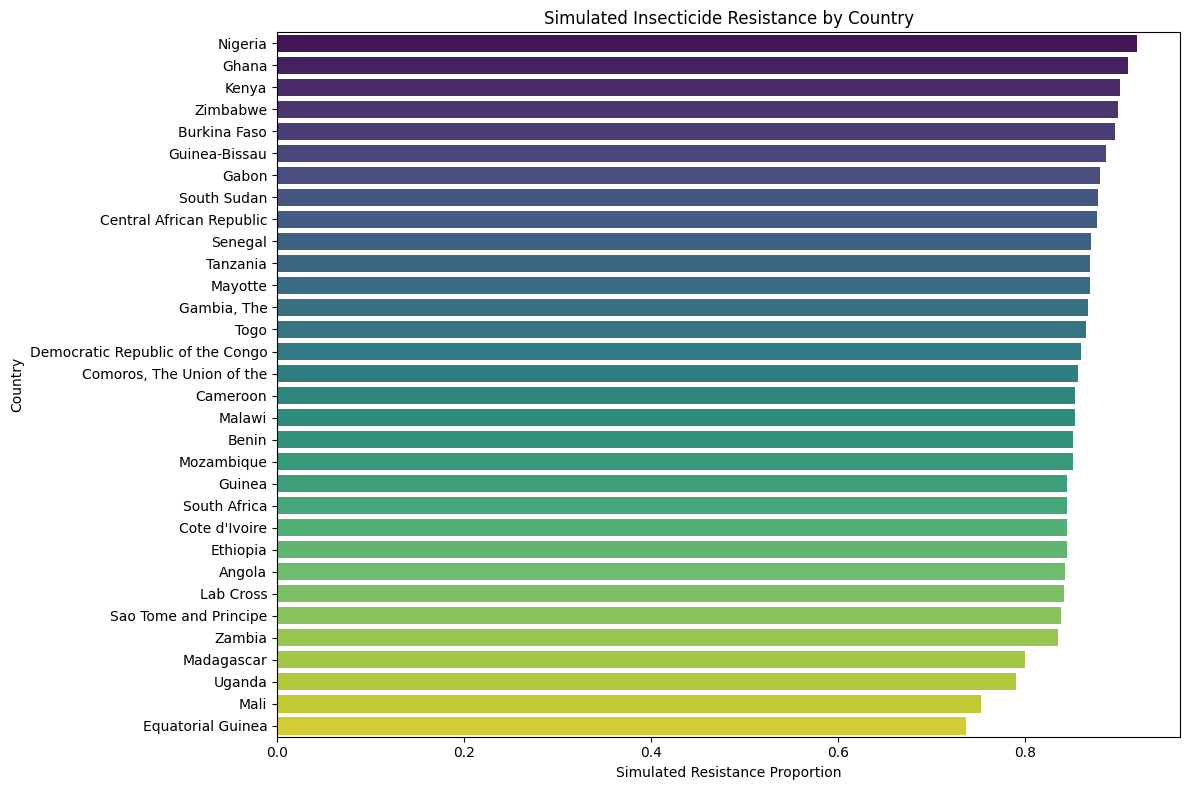

In [5]:
# Join metadata and phenotype series
pheno_series_named = pheno_series.rename("phenotype_binary")
res_by_country = pd.concat([sim.meta.set_index('sample_id')["country"], pheno_series_named], axis=1, join='inner')

# Group by country and compute mean resistance
avg_resistance_by_country = res_by_country.groupby("country")["phenotype_binary"].mean().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=avg_resistance_by_country.values, y=avg_resistance_by_country.index, palette="viridis")
plt.xlabel("Simulated Resistance Proportion")
plt.ylabel("Country")
plt.title("Simulated Insecticide Resistance by Country")
plt.tight_layout()
plt.show()

### 6. Quick Summaries

In [6]:
# Ensure phenotype series has a proper name for the column
pheno_series_named = pheno_series.rename("phenotype_binary")

# Join metadata and phenotype series
meta = sim.meta.set_index("sample_id")
res_by_country = pd.concat([meta["country"], pheno_series_named], axis=1)

# Group by country and compute mean resistance
avg_resistance_by_country = res_by_country.groupby("country")["phenotype_binary"].mean()

print(avg_resistance_by_country)


country
Angola                              0.842697
Benin                               0.851585
Burkina Faso                        0.896772
Cameroon                            0.853792
Central African Republic            0.876712
Comoros, The Union of the           0.857143
Cote d'Ivoire                       0.845070
Democratic Republic of the Congo    0.859813
Equatorial Guinea                   0.736842
Ethiopia                            0.844560
Gabon                               0.880150
Gambia, The                         0.867707
Ghana                               0.910032
Guinea                              0.845426
Guinea-Bissau                       0.886957
Kenya                               0.902290
Lab Cross                           0.841751
Madagascar                          0.800000
Malawi                              0.853659
Mali                                0.752711
Mayotte                             0.869565
Mozambique                          0.851351
Ni